In [2]:
from __future__ import print_function
import warnings
from time import time
import logging
import glob
from pathlib import Path

import librosa #  conda install -c conda-forge librosa 
import wave
import scipy.io.wavfile as wav
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier
from skimage.io import imread
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

print(__doc__)

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')
warnings.filterwarnings("ignore")

Automatically created module for IPython interactive environment


In [3]:
def load_raw_data(audio_path):
    samples_data = []
    sample_data_rates = []
    file_names = []

    for file in Path(audio_path).glob("**/*.wav"):
        if not file.is_file():  # Skip directories
            continue

        sample_rate, samples = wav.read(file)
        samples_data.append(samples)
        sample_data_rates.append(sample_rate)
        
        file_names.append(file.name)

    return samples_data, sample_data_rates, file_names

def save_wav_spectrogram(data, rate, file_name, image_size):
    fig, ax = plt.subplots(1)
    fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1)
    ax.axis('off')

    ax.specgram(x = data, Fs = rate, noverlap = 384, NFFT = 512)
    ax.axis('off')

    DPI = fig.get_dpi()
    fig.set_size_inches(image_size/float(DPI), image_size/float(DPI))
    
    fig.savefig(file_name, frameon = 'false')

def wav_spectograms_to_images(samples, sample_rates, file_names, image_size):
    img_dir = './images/'
    total_samples = len(samples)
    for index, sample in enumerate(samples):
        file_name = img_dir + (file_names[index].rsplit('.', 1)[0]) + '.png' # remove .wav
        print('Processing file: %s (%d/%d)' %(file_name, index, total_samples))
        save_wav_spectrogram(sample, sample_rates[index], file_name, image_size)


In [16]:
# Generate spectograms images and save it on local dir.
image_folder = Path("./images")

if image_folder.is_dir():
    print ("Already exist")
else:
    try:
        Path('./images').mkdir() 
        wav_data, sample_rates, file_names = load_raw_data('./recordings')
        wav_spectograms_to_images(wav_data, sample_rates, file_names, 64.0)
    except e:
        Path('./images').unlink()  
        print(e)

Already exist


## Data Analysis 

https://medium.com/@mikesmales/sound-classification-using-deep-learning-8bc2aa1990b7

"Sound excerpts are digital audio files in .wav format. Sound waves are digitised by sampling them at discrete intervals known as the sampling rate (typically 44.1kHz for CD quality audio meaning samples are taken 44,100 times per second).

Each sample is the amplitude of the wave at a particular time interval, where the bit depth determines how detailed the sample will be also known as the dynamic range of the signal (typically 16bit which means a sample can range from 65,536 amplitude values)."

The Free Spoken Digit Dataset (FSDD) info:


- 4 speakers
- 2,000 recordings (50 of each digit per speaker)
- English pronunciations

In [37]:
wave_sample = wave.open('./recordings/0_jackson_0.wav')
print('wav info:', wave_sample.getparams())

wave_sample.close()

wav info: _wave_params(nchannels=1, sampwidth=2, framerate=8000, nframes=5148, comptype='NONE', compname='not compressed')


## Spectrogram approach

In [211]:
def get_data_from_spectrogram_images(images_path):
    labels = []
    image_data = []
    for file in Path(images_path).glob("**/*.png"):
        label = file.name.split('_')[0]
        labels.append(label)
        image_data.append(imread(images_path + file.name, as_gray=True))
    
    return np.asanyarray(image_data), np.asarray(labels)

def show_spectrogram_classes(classes, speakers):
    fig = plt.figure(figsize = (16, 16))
    for index, speaker in enumerate(speakers):
        for j in range(1, classes + 1):
            file_name = str(j - 1) + '_' + speaker + '_' + '0.png'
            img = mpimg.imread('./images/' + file_name)

            ax = fig.add_subplot(len(speakers), classes, j + (index * classes))
            ax.set_title(speaker + ' - ' + str(j - 1))
            ax.axis('off')

            plt.imshow(img)
    plt.show()

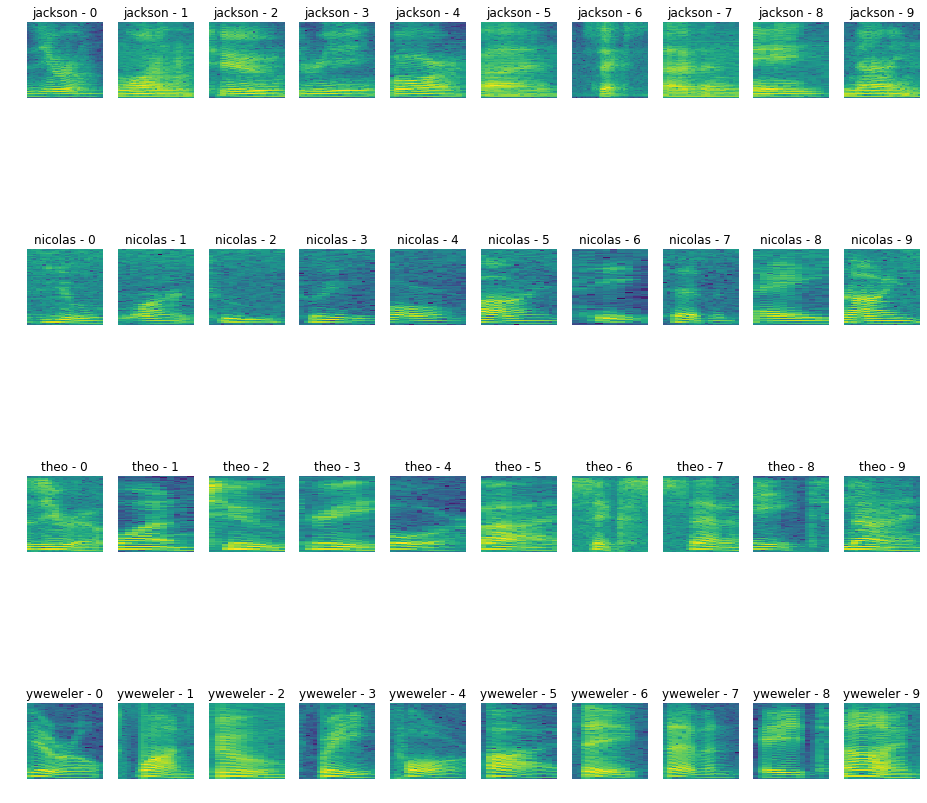

In [179]:
mask_classes_speakers = ['jackson', 'nicolas', 'theo', 'yweweler']
show_spectrogram_classes(10, mask_classes_speakers)

In [231]:
X, labels = get_data_from_spectrogram_images('./images/')

n_classes = len(np.unique(labels))
n_samples, nx, ny = X.shape
n_features = nx * ny

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 2000
n_features: 4096
n_classes: 10


In [232]:
encoder = preprocessing.LabelEncoder() # One Hoc Encode
y = encoder.fit_transform(labels)

X = X.reshape(n_samples, n_features)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [227]:
print("Fitting the classifier to the training set")
t0 = time()

parameters = {'solver': ['adam'], 'max_iter': [1000], 'alpha': 10.0 ** -np.arange(3, 5), 'hidden_layer_sizes':[250], 'random_state':[0, 1], 'early_stopping':[True]}

clf = GridSearchCV(MLPClassifier(), parameters, n_jobs = -1, cv = 3)
clf = clf.fit(X_train, y_train)

print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)
print("Best applied model params:")
print(clf.best_params_)
print("Train Score: ")
print(clf.score(X_train, y_train))

Fitting the classifier to the training set
done in 557.664s
Best estimator found by grid search:
MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=250, learning_rate='constant',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=0, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)
Best applied model params:
{'alpha': 0.001, 'early_stopping': True, 'hidden_layer_sizes': 250, 'max_iter': 1000, 'random_state': 0, 'solver': 'adam'}
Train Score: 
0.956


In [236]:
# #############################################################################
# Quantitative evaluation of the model quality on the test set

target_names = ['digit_' + x for x in np.unique(labels)] 

print("Predicting digits on the test set")
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred, target_names=target_names))
print("Confusion matrix")
print(confusion_matrix(y_test, y_pred, labels = range(n_classes)))

Predicting people's names on the test set
              precision    recall  f1-score   support

     digit_0       1.00      0.95      0.97        59
     digit_1       1.00      0.94      0.97        49
     digit_2       0.89      0.96      0.92        51
     digit_3       0.89      0.89      0.89        53
     digit_4       0.96      1.00      0.98        50
     digit_5       0.95      0.93      0.94        44
     digit_6       0.77      0.79      0.78        42
     digit_7       0.93      0.98      0.95        52
     digit_8       0.89      0.90      0.90        52
     digit_9       1.00      0.92      0.96        48

   micro avg       0.93      0.93      0.93       500
   macro avg       0.93      0.93      0.93       500
weighted avg       0.93      0.93      0.93       500

Confusion matrix
[[56  0  1  0  0  0  0  2  0  0]
 [ 0 46  0  0  1  2  0  0  0  0]
 [ 0  0 49  1  0  0  1  0  0  0]
 [ 0  0  2 47  0  0  3  0  1  0]
 [ 0  0  0  0 50  0  0  0  0  0]
 [ 0  0  0  0  1 

## Mel-Frequency Cepstrum Coefficient

In [20]:
# https://github.com/adhishthite/sound-mnist/blob/master/utils/wav2mfcc.py
def wav2mfcc(file_path, max_pad_len=20):
    wave, sr = librosa.load(file_path, mono=True, sr=None)
    wave = wave[::3]
    mfcc = librosa.feature.mfcc(wave, sr=8000)
    pad_width = max_pad_len - mfcc.shape[1]
    mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')

    return mfcc

def load_mfcc_data(audio_path):
    data = []
    labels = []

    for file in Path(audio_path).glob("**/*.wav"):
        if not file.is_file():  # Skip directories
            continue
        
        label = file.name.split('_')[0]
        labels.append(label)
        
        data.append(wav2mfcc(audio_path + file.name))
    
    return np.asanyarray(data), labels

In [21]:
X, labels = load_mfcc_data('./recordings/')

n_classes = len(np.unique(labels))
n_samples, nx, ny = X.shape
n_features = nx * ny

encoder = preprocessing.LabelEncoder() # One Hoc Encode
y = encoder.fit_transform(labels)

X = X.reshape(n_samples, n_features)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [22]:
print("Fitting the classifier to the training set")
t0 = time()

parameters = {'solver': ['adam'], 'max_iter': [1000], 'alpha': 10.0 ** -np.arange(3, 5), 'hidden_layer_sizes':[512], 'random_state':[0, 1], 'early_stopping':[True]}

clf = GridSearchCV(MLPClassifier(), parameters, n_jobs = -1, cv = 3)
clf = clf.fit(X_train, y_train)

print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)
print("Best applied model params:")
print(clf.best_params_)
print("Train Score: ")
print(clf.score(X_train, y_train))

Fitting the classifier to the training set
done in 52.202s
Best estimator found by grid search:
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=512, learning_rate='constant',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=0, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)
Best applied model params:
{'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': 512, 'max_iter': 1000, 'random_state': 0, 'solver': 'adam'}
Train Score: 
0.9846666666666667


In [23]:
# #############################################################################
# Quantitative evaluation of the model quality on the test set

target_names = ['digit_' + x for x in np.unique(labels)] 

print("Predicting digits on the test set")
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred, target_names=target_names))
print("Confusion matrix")
print(confusion_matrix(y_test, y_pred, labels = range(n_classes)))

Predicting digits on the test set
              precision    recall  f1-score   support

     digit_0       0.93      0.93      0.93        41
     digit_1       0.87      0.90      0.89        60
     digit_2       0.90      0.87      0.88        53
     digit_3       0.85      0.83      0.84        42
     digit_4       0.96      0.88      0.92        57
     digit_5       0.88      0.92      0.90        39
     digit_6       0.88      0.89      0.88        56
     digit_7       0.98      0.89      0.93        54
     digit_8       0.85      0.94      0.89        49
     digit_9       0.87      0.92      0.89        49

   micro avg       0.90      0.90      0.90       500
   macro avg       0.90      0.90      0.90       500
weighted avg       0.90      0.90      0.90       500

Confusion matrix
[[38  0  1  1  0  0  0  0  0  1]
 [ 0 54  0  0  1  2  0  0  0  3]
 [ 2  0 46  3  0  0  1  0  1  0]
 [ 0  0  3 35  0  0  3  0  1  0]
 [ 0  4  0  0 50  2  1  0  0  0]
 [ 0  1  0  0  0 36  0  0